# Dataproject

## Imports and set magics

In [1]:
#!pip install EurostatAPIClient

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from IPython.display import display

from eurostatapiclient import EurostatAPIClient # eurostat API

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject as dp

## Scope

The data has been chosen to examine air travel patterns across the current European Union members since 1998. We will be able to figure out if there is a connection between income and degree of air travel. The period of the data was chosen due to the fact, that it will cover the Dot-com bubble, the financial crisis of 2007-2008 as well as the corona pandemic.


# The data

Initial setup of API

In [3]:
# initializing the Eurostat API client
client = EurostatAPIClient('v2.1','json','en')

When fetching data the Eurostat API requires some parameters such as units of measurement, period, frequency etc. depending on the dataset. Parameters must be given to the API in a list of tuples containing parameter name and value. We want to examine the period 1998-2020 for all datasets. A list of tuples of time-parameters are created using list comprehension.

In [4]:
# setting the time parameter to use in all dataset fetches
time_param = [('time',f'{i}') for i in reversed(range(1998,2021))]

## Importing and cleaning datasets

### Passenger numbers

For the dataset "Aircraft traffic data by reporting country" (avia_tf_acc) parameters `unit`, `freq`, `tra_cov`, `tra_meas` and `aircraft` should be defined. The parameters set below basically means we want the annual number of actually boarded passenger for all types of aircraft for domestic and international flights. Please refer to [the dataset](https://ec.europa.eu/eurostat/databrowser/view/avia_tf_acc/default/table?lang=en "Eurostat") for more info.

In [5]:
# a. setting parameters for this dataset
params = [('unit','PAS'),('freq','A'),('tra_cov','TOTAL'),('tra_meas','PAS_BRD'),('aircraft','TOTAL')] + time_param

# b. fetching the dataset as a dataframe
pas = dp.eurostat_to_df('avia_tf_acc', params, client)

The dataset title is:
Aircraft traffic data by reporting country


,values,unit,tra_meas,tra_cov,aircraft,geo,time
0,12732342.0,PAS,PAS_BRD,TOTAL,TOTAL,AT,1998
1,13276983.0,PAS,PAS_BRD,TOTAL,TOTAL,AT,1999
2,14220561.0,PAS,PAS_BRD,TOTAL,TOTAL,AT,2000
3,14138385.0,PAS,PAS_BRD,TOTAL,TOTAL,AT,2001
4,14625165.0,PAS,PAS_BRD,TOTAL,TOTAL,AT,2002


Cleanup: There are obviously some columns we don't want. More specifically the columns `unit`, `tra_meas`, `tra_cov` and `aircraft`. We also want to rename the `values` column to remind us what the values actually are.

In [6]:
# cleaning up - renaming values and removing unwanted cols
drop_these = ['unit','tra_meas','tra_cov','aircraft']
dp.clean_eurostat_df(pas, drop_these, 'passengers')

,passengers,geo,time
0,12732342.0,AT,1998
1,13276983.0,AT,1999
2,14220561.0,AT,2000
3,14138385.0,AT,2001
4,14625165.0,AT,2002


### Real GDP per capita

For the dataset "Main GDP aggregates per capita" (nama_10_pc) parameters `unit` and `na_item` should be defined. The parameters set below means we will get ___real___ GDP per capita in EUR. Please refer to [the dataset](https://ec.europa.eu/eurostat/databrowser/view/NAMA_10_PC/default/table "Eurostat") for more info.

In [7]:
# a. setting parameters for this dataset
params = [('unit','CLV10_EUR_HAB'),('na_item','B1GQ')] + time_param

# b. fetching the dataset as a dataframe
gdp_cap = dp.eurostat_to_df('nama_10_pc', params, client)

The dataset title is:
Main GDP aggregates per capita


,values,unit,na_item,geo,time
0,29750.0,CLV10_EUR_HAB,B1GQ,AT,1998
1,30750.0,CLV10_EUR_HAB,B1GQ,AT,1999
2,31710.0,CLV10_EUR_HAB,B1GQ,AT,2000
3,31990.0,CLV10_EUR_HAB,B1GQ,AT,2001
4,32360.0,CLV10_EUR_HAB,B1GQ,AT,2002


Cleanup: Again there are columns we don't want: `unit` and `na_item`. We also rename the `values` column.

In [8]:
# cleaning up - renaming values and removing unwanted cols
drop_these = ['unit','na_item']
dp.clean_eurostat_df(gdp_cap, drop_these, 'gdp_cap')

,gdp_cap,geo,time
0,29750.0,AT,1998
1,30750.0,AT,1999
2,31710.0,AT,2000
3,31990.0,AT,2001
4,32360.0,AT,2002


### Population figures

For the dataset "Population on 1 January by age and sex" (demo_pjan) parameters `age` and `sex` should be defined. The parameters set below means we will only get the figure for the entire population (all ages and sex). Please refer to [the dataset](https://ec.europa.eu/eurostat/databrowser/view/DEMO_PJAN/default/table "Eurostat") for more info.

In [9]:
# a. setting parameters for this dataset
params = [('age','TOTAL'),('sex','T')] + time_param

# b. fetching the dataset as a dataframe
pop = dp.eurostat_to_df('demo_pjan', params, client)

The dataset title is:
Population on 1 January by age and sex


,values,unit,age,sex,geo,time
0,65306.0,NR,TOTAL,T,AD,1998
1,65877.0,NR,TOTAL,T,AD,1999
2,65971.0,NR,TOTAL,T,AD,2000
3,65844.0,NR,TOTAL,T,AD,2001
4,66334.0,NR,TOTAL,T,AD,2002


Cleanup: Removing `unit`, `sex` and `age`. Renaming `values` to `population`.

In [10]:
# cleaning up - renaming values and removing unwanted cols
drop_these = ['unit','sex','age']
dp.clean_eurostat_df(pop, drop_these, 'population')

,population,geo,time
0,65306.0,AD,1998
1,65877.0,AD,1999
2,65971.0,AD,2000
3,65844.0,AD,2001
4,66334.0,AD,2002


## The full dataset

### Merging

Since we imported the dataset with the same time-parameters, the same years should be available in all 3 datasets, but the geo-identifiers are not the same in all datasets as evident below:

In [11]:
print(
    f'geo in pas: {len(pas.geo.unique()):6}\n'
    f'geo in gdp_cap: {len(gdp_cap.geo.unique()):2}\n'
    f'geo in pop: {len(pop.geo.unique()):6}'
)

geo in pas:     38
geo in gdp_cap: 41
geo in pop:     59


Some of the datasets contain geo identifiers that are not present in the others. We are however only interested in the [EU27 2020 countries](https://en.wikipedia.org/wiki/Member_state_of_the_European_Union) (the countries remaining in EU since UK left last year). All three datasets should contain values for these countries.

We can merge the three datasets by the 'inner' method, since we don't mind losing any of the values that are not present in all three datasets.

In [12]:
full = dp.merge_dfs(pas,gdp_cap,pop,on=['geo','time'],how='inner')

,passengers,geo,time,gdp_cap,population
0,12732342.0,AT,1998,29750.0,7971116.0
1,13276983.0,AT,1999,30750.0,7982461.0
2,14220561.0,AT,2000,31710.0,8002186.0
3,14138385.0,AT,2001,31990.0,8020946.0
4,14625165.0,AT,2002,32360.0,8063640.0


### Layout and remove rows

We want to make this a little more readable. The country codes in the geo column can be found [here](https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Country_codes). They are listed in a dictionary below:

In [13]:
eu27_2020 = {
        'BE' : 'Belgium','BG' : 'Bulgaria','CZ' : 'Czechia','DK' : 'Denmark',
        'DE' : 'Germany','EE' : 'Estonia','IE' : 'Ireland','EL' : 'Greece',
        'ES' : 'Spain','FR' : 'France','HR' : 'Croatia','IT' : 'Italy',
        'CY' : 'Cyprus','LV' : 'Latvia','LT' : 'Lithuania','LU' : 'Luxembourg',
        'HU' : 'Hungary','MT' : 'Malta','NL' : 'Netherlands','AT' : 'Austria',
        'PL' : 'Poland','PT' : 'Portugal','RO' : 'Romania','SI' : 'Slovenia',
        'SK' : 'Slovakia','FI' : 'Finland','SE' : 'Sweden'
        }

Not all the EU country codes makes sense, so we will create a new column `geo_name`, that contains the written name corresponding to the country code in `geo`. We will also move the passengers column to the end.

In [14]:
# a. inserting new column: geo codes converted to country names using above dictionary
full.insert(0, 'geo_name',full.geo.apply(dp.code_to_name,code_dict=eu27_2020))

# b. moving passengers to the end
move_col = full.pop('passengers')
full.insert(len(full.columns)-1, 'passengers', move_col) # inserting at the last index: length-1

A logical index using the keys from the eu27_2020 dictionary, shows that the dataframe still contains rows that are either not countries or countries that are not part of European Union (such as EU27_2007, Switzerland and United Kingdoms):

In [15]:
# logical index for eu27 dictionary geo keys
I = full.geo.isin(list(eu27_2020.keys())) == True
full[I == False]

,geo_name,geo,time,gdp_cap,passengers,population
69,,CH,1998,49750.0,24163688.0,7096465.0
70,,CH,1999,50350.0,26073588.0,7123537.0
71,,CH,2000,52080.0,31355646.0,7164444.0
72,,CH,2001,52640.0,29509345.0,7204055.0
73,,CH,2002,52260.0,25679686.0,7255653.0
...,...,...,...,...,...,...
846,,UK,2016,32060.0,249076212.0,65379044.0
847,,UK,2017,32430.0,264867264.0,65844142.0
848,,UK,2018,32640.0,272386344.0,66273576.0
849,,UK,2019,32910.0,277548891.0,66647112.0


The dataset should only contain the rows in the logical index `I` (ie. rows where `geo` is contained in the eu27_2020 dict).

In [16]:
# a. removing rows not contained in I
full = full.loc[I]

# b. resetting index
full.reset_index(drop=True, inplace=True)

# c. checking if full now has 27 countries
print(f'The european union has {len(full.geo.unique())} countries.')

The european union has 27 countries.


# Working with the data

## Hypothesis

**Hypothesis:** Richer countries have a higher degree of air travel. They should have more tourist (both visiting and travelling abroad) and more companies who are trading and travelling internationally.

## Adding variables

### Passengers per capita

It doesn't make sense to compare the number of passengers to GDP per capita. We need a measurement of the degree of air travel. Thus we create a new variable `pas_cap` which is `passengers` divided by `population`.

In [17]:
# a. index of gdp_cap
i = full.columns.get_loc('gdp_cap')

# b. new column pas_cap after gdp_cap
full.insert(i+1, 'pas_cap', full.passengers/full.population)

### Yearly percentual change

We want to be able to have a look percentual change in `gdp_cap` and `pas_cap` over the years for each country. Pandas has a built in function `.pct_change()` that we apply to all values in a column grouped by country.

In [18]:
# a. create copy and define group
full_ = full.copy()
group = 'geo' # group by country

# b. apply pct_change
dp.add_pct_col(full_,group,'gdp_cap')
dp.add_pct_col(full_,group,'pas_cap')

### Inspecting the outcome

In [19]:
# a. function to call in widget
country_table = lambda x,y: full_[full_['geo_name']==x].head(y)

# b. creating the widget
widgets.interact(country_table,
    x = widgets.Dropdown(description='Country:',
                                 options=full.geo_name.unique(),
                                 value='Netherlands'),
    y = widgets.IntSlider(description='years: ',
                                 min=1,max=23,value=7)
);

interactive(children=(Dropdown(description='Country:', index=20, options=('Austria', 'Belgium', 'Bulgaria', 'C…

Three new columns are now present: `pas_cap`, `gdp_cap_pct` and `pas_cap_oct`. However when going through the tables, something odd about the data for Netherlands strikes the eye. Between 2001 and 1998 (no pas_cap data between those year) there is allegedly a growth of 8793.5% in `pas_cap` which seems rather excessesive. Passenger numbers show only 433911 passengers for 1998, which is very low in comparison with the later periods.

I did some digging and in [this annual report (page 12)](https://assets.ctfassets.net/1msjktcn08sc/2oYJeNESFeam2ecuQ8sOOw/f2d667c5a08898be4e99b2fb0e830e0a/1998_annual_report_en_v1_m56577569830810436.pdf#page=12) Schiphol Airport alone should have had more than 34 mio. passengers in 1998. Lets remove the `pas_cap`, `passengers` values at index 460 and `pas_cap_pct` at index 463 (ie. set them as NaN).

In [20]:
# a. define values to be modified
i, i2 = 460,463

set_nan = [full_['pas_cap'][i],
           full_['passengers'][i],
           full_['pas_cap_pct'][i2]]

# b. replace the values
full_ = full_.replace(set_nan, np.nan)

# c. inspect those indices, to ensure values are correctly NaN
full_.iloc[460:464]

,geo_name,geo,time,gdp_cap,pas_cap,passengers,population,gdp_cap_pct,pas_cap_pct
460,Netherlands,NL,1998,32480.0,NaN,NaN,15654192.0,NaN,NaN
461,Netherlands,NL,1999,33890.0,NaN,NaN,15760225.0,4.341133,NaN
462,Netherlands,NL,2000,35060.0,NaN,NaN,15863950.0,3.452346,NaN
463,Netherlands,NL,2001,35610.0,2.465137,39410331.0,15987075.0,1.568739,NaN


## Analysis

### Economic output vs air travel activity

In [21]:
# widget for plotting gdp_cap and pas_cap for eu27 countries

widgets.interact(dp.plot_gdp_pas_cap, 
    df = widgets.fixed(full),
    geo_name = widgets.Dropdown(description='Country:', 
                                    options=full.geo_name.unique(), 
                                    value='Sweden')
);

interactive(children=(Dropdown(description='Country:', index=24, options=('Austria', 'Belgium', 'Bulgaria', 'C…

Generally: Some countries have missing data. For instance Croatia didn't join EU until 2013, so a lot of data is missing for the first half of the period and many countries have not had their numbers for 2020 registered yet. There is a clear correlation between GDP and the degrees of air travel for many countries. For countries with data for 2020, it is obvious that the corona-pandemic has taken a large toll on the passenger numbers - which makes sense since the aviation industry might be the sector, that has taken the largest blow.

Take a look at the graphs for:
- **Sweden:** the correlation between `gdp_cap` and `pas_cap` is very clear. There is a small dive in `pas_cap` around 2001, which could be due to the dot.com bubble and/or the September 11 attacks on World Trade Center.
- **Germany:** passengers per capita broadly follows the development of GDP per capita. It is obvious that the corona pandemic has hit the aviation industry harder than the rest of the economy.
- **Greece or Italy:** the economical damage following the financial crisis of 2007-2008 has lasted for a very long time, however passengers per capita has exploded (probably due to tourism from other recovered economies).

### Closer look at the correlation

Lets check if the correlation indeed is present for the countries overall. First we'll take the mean of `gdp_cap` and `pas_cap` for each country, plot the scatters and make a regression. We will also plot the correlation between the percentage growth in GDP per capita and the percentage growth in passengers per capita.

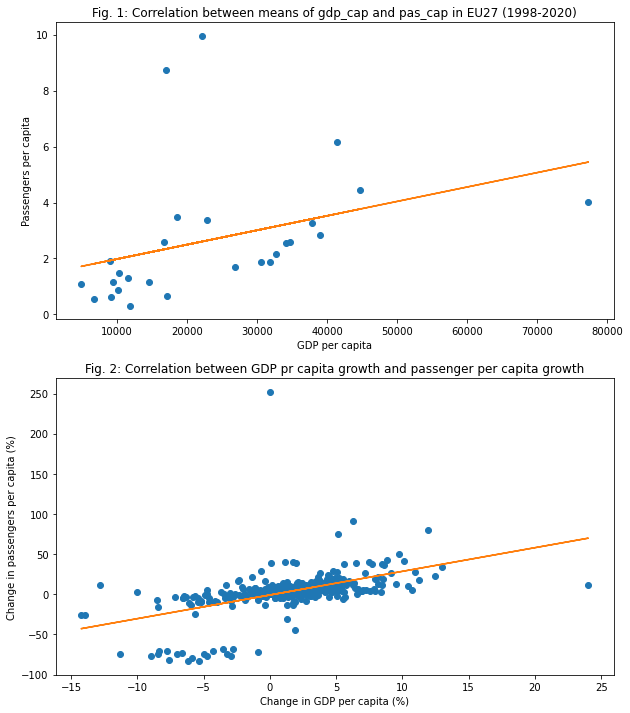

In [22]:
# a. country means over the period
x = full_.groupby('geo')['gdp_cap'].mean()
y = full_.groupby('geo')['pas_cap'].mean()

# b. percentual changes
data = full_[['gdp_cap_pct','pas_cap_pct']].dropna() # dropping NaNs for np.polyfit
x2 = data['gdp_cap_pct'] 
y2 = data['pas_cap_pct']

# c. create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,12))

# d. titles
ax1.set_xlabel('GDP per capita')
ax1.set_ylabel('Passengers per capita')
ax1.set_title('Fig. 1: Correlation between means of gdp_cap and pas_cap in EU27 (1998-2020)')

ax2.set_xlabel('Change in GDP per capita (%)')
ax2.set_ylabel('Change in passengers per capita (%)')
ax2.set_title('Fig. 2: Correlation between GDP pr capita growth and passenger per capita growth')

# e. plot contents
ax1.plot(x,y,'o') # scatter plot of means
a, b = np.polyfit(x,y,1) # linear regression
ax1.plot(x,a*x + b); 

ax2.plot(x2,y2,'o') # scatter plot of pct changes
a, b = np.polyfit(x2,y2,1) # linear regression
ax2.plot(x2,a*x2 + b);

Figure 1 shows us that richer countries have had a higher degree of air travel over the period. Figure 2 shows that within countries, a growth in GDP per capita is generally associated with growth in passengers per capita. The group of outliers in the bottom left corner are very likely due to the corona pandemic, where GDP per capita has declined, but passengers per capita has declined to an even greater unprecedented degree.

We can also confirm that the corellation coefficient between the average gdp_cap and pas_cap between the countries is indeed positive as well as the coefficient between the percentual changes. Using `np.corrcoef`.

In [23]:
print(f'Pearson correlation coefficient between the countries mean gdp_cap and mean pas_cap is: {np.corrcoef([x,y])[0,1]:.4f}')
print(f'Pearson correlation coefficient between the countries gdp_cap_pct and pas_cap_pct is: {np.corrcoef([x2,y2])[0,1]:.4f}')

Pearson correlation coefficient between the countries mean gdp_cap and mean pas_cap is: 0.3512
Pearson correlation coefficient between the countries gdp_cap_pct and pas_cap_pct is: 0.5071


# Conclusion

We have documented a positive correlation between GDP per capita and passengers per capita. We cannot with certainty say the exact cause and effect for this, but we can speculate:

- a wealthy population travels more
- many high output companies are often internationally dependant (business trips)
- countries getting higher GDP from having many tourists
- the other way around, the richer a country, the more popular it is for tourists

In [24]:
# checking average growth over the period for all countries
print(f'From 1998 to 2020, for all EU27 countries the average growth in')
print(f'GDP per capita: {full_.gdp_cap_pct.mean():.2f}%')
print(f'Passengers per capita: {full_.pas_cap_pct.mean():.2f}%')

From 1998 to 2020, for all EU27 countries the average growth in
GDP per capita: 1.96%
Passengers per capita: 4.12%


The average growth is passengers per capita is larger than the average growth in GDP per capita as seen above. We get the same picture when looking at the graphs for each country in 3.3.1. There is a general tendency of larger growth in air travel than income. For some countries by a factor 3-4 for the period. We can speculate that this is due to:

- a change of culture for more travel
- more low-cost carriers

We have learned to use an API to import data and how to clean up that data for desired usage. Furthermore we have learned to add variables and apply functions to an entire column as well as using the different functions built in to pandas for analysing data in a series or dataframe.

For good measure and ability to inspect the data outside python, we will end by exporting the dataframe.

In [25]:
# exporting dataframe as excel
full_.to_excel('data/eu27_pas_gdp.xlsx')